Нам даны данные о поездках и пользователях сервиса аренды самокатов GoFast. Поставлена задача, на основании имеющихся датафреймов сделать выводы, которые в будущем помогут компании лучше понимать клиентов и сделать полезные выводы для улучшения бизнеса. Итоговой целью будет проверка некоторых гипотез.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [11]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
sub = pd.read_csv('/datasets/subscriptions_go.csv')

In [12]:
display(users.head())
display(users.info())

display(rides.head())
display(rides.info())

display(sub.head())
display(sub.info())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


None

Имеем три набора данных с информацией о пользователях сервиса аренды самокатов GoFast. Записали наборы данных в соответствующие датафреймы, вывели общую информацию о наборах данных и первые строчки из них. Дана информация о 1565 пользователях, их типу подписки, их возрасту и городу в котором они пользовались сервисом; информация о 18068 поездках, их продолжительности. В датафреймах нет пропусков, все числовые значения уже приведены к типу int, где это нужно.

#### Шаг 2. Предобработка данных

In [13]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
display(rides.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


None

In [14]:
rides['month'] = rides['date'].dt.month

Перевели тип данных в столбце 'date' в datetime и добавили столбец с номером месяца в датафрейм rides.

In [15]:
display(users.duplicated().sum())
display(rides.duplicated().sum())
display(sub.duplicated().sum())

31

0

0

In [16]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

Дубликаты были только в таблице с данными пользователей, удалили их и обновили индексы.

В ходе предобработки данных изменили тип данных в столбце 'date' на datetime и избавились от дубликатов в датафрейме с данными пользователей

#### Шаг 3. Исследовательский анализ данных

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: user_id, dtype: int64

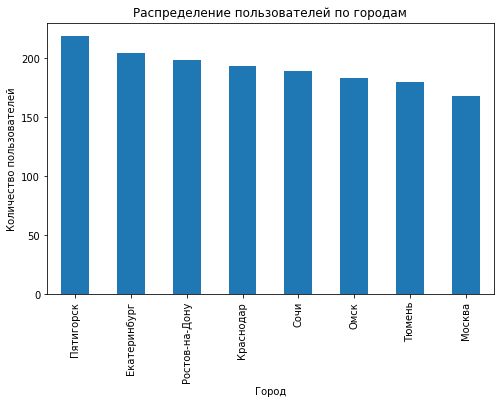

In [17]:
# Просмотрим частоту встречаемости городов
city_counts = users.groupby('city')['user_id'].count().sort_values(ascending=False)
display(city_counts)

# Визуализация
plt.figure(figsize=(8,5))
city_counts.plot(kind='bar')
plt.title('Распределение пользователей по городам')
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

Видим, что больше всего пользуются сервисом в Пятигорске, Екатиренбурге и Ростове-на-Дону, а меньше всего в Москве, но различия слишком незначительны для заключения какого-либо вывода.

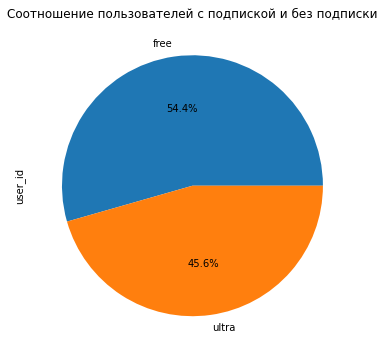

subscription_type
free     835
ultra    699
Name: user_id, dtype: int64

In [18]:
# Оценим соотношение пользователей с подпиской и без подписки
users.groupby('subscription_type')['user_id'].count().plot(kind = 'pie',figsize = (6,6), autopct='%1.1f%%')
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.show()
users.groupby('subscription_type')['user_id'].count()

Видим, что кол-во пользователей с подпиской ultra и без нее почти одинаково, но все равно большинство пользуется бесплатной версией.

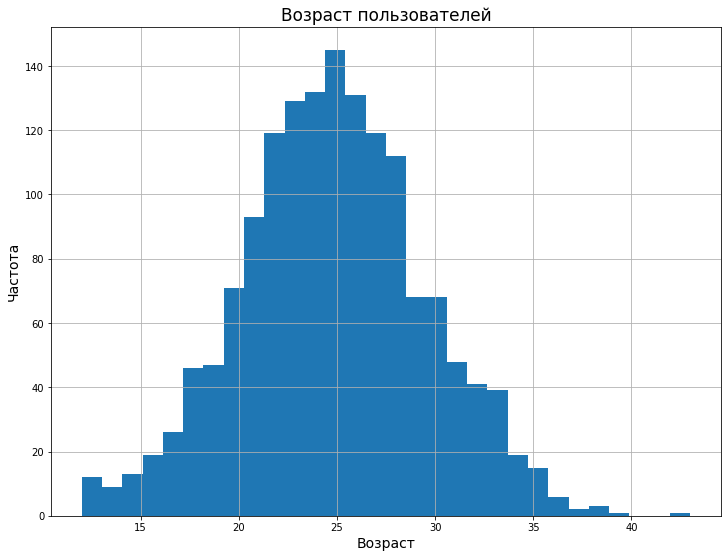

In [19]:
# Возраст пользователей
users['age'].hist(bins = 30, figsize = (12,9))
plt.title('Возраст пользователей', size = 17)
plt.xlabel('Возраст', size = 14)
plt.ylabel('Частота', size = 14)
plt.show()

По графику четко видно, что распределение возрастов пользователей близко к нормальному виду. Больше всего пользователей 25 лет, хотя есть и значения и меньше 5 лет, и больше 45.

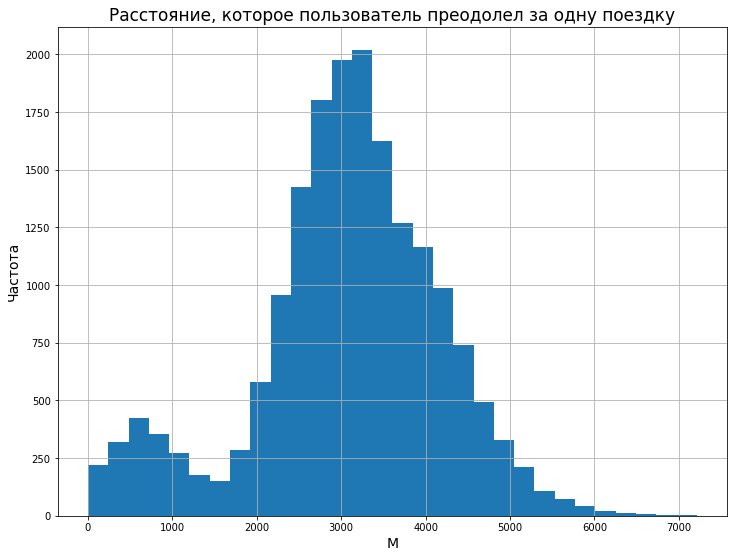

In [20]:
# Расстояние, которое пользователь преодолел за одну поездку
rides['distance'].hist(bins = 30, figsize = (12,9))
plt.title('Расстояние, которое пользователь преодолел за одну поездку', size = 17)
plt.xlabel('М', size = 14)
plt.ylabel('Частота', size = 14)
plt.show()

Мы получили график распределения киллометража поездки. Он имеет почти нормальный вид, помимо области до 1.5км. Это отклонение говорит нам о том, что часть пользователей предпочитает пользоваться сервисом вместо недолгой прогулки или использования общ. транспорта. Самой частой дистанцией выступают значения от 3 до 3.5 км.

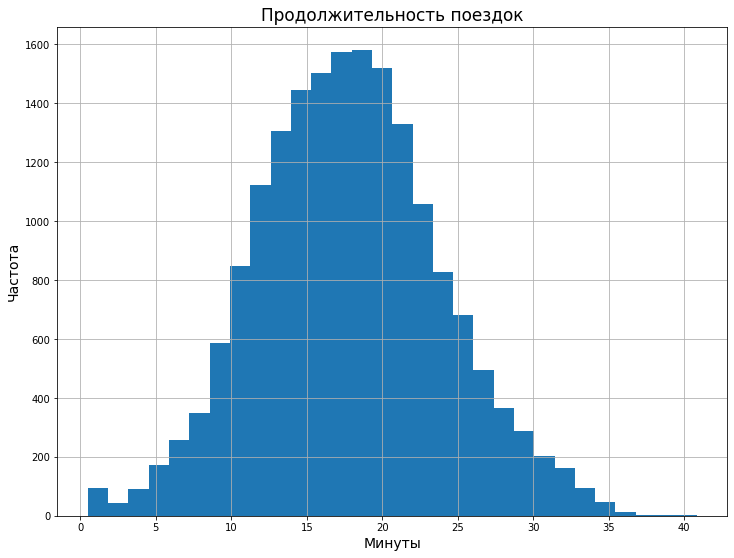

Минимальная продолжительность: 0.5
Максимальная продолжительность: 40.82396261922424


In [21]:
# Продолжительность поездок
rides['duration'].hist(bins = 30, figsize = (12,9))
plt.title('Продолжительность поездок' ,size = 17)
plt.xlabel('Минуты', size = 14)
plt.ylabel('Частота', size = 14)
plt.show()

print('Минимальная продолжительность:', rides['duration'].min())
print('Максимальная продолжительность:', rides['duration'].max())

Мы снова получили нормальное распределение, с центром в значении около 17 минут. Значит это самая распространенная продолжительность, а остальные значения стремятся к нему. Так же были получены значения максимума и минимума. Пользователи проводили в поездке от 0.5 до 40 минут.

После проведения исследовательского анализа данных выяснили следующее:

- Частота встречаемости городов
    - Больше всего пользуются сервисом в Пятигорске, Екатиренбурге и Ростове-на-Дону, а меньше всего в Москве, но различия незначительны.
- Соотношение пользователей с подпиской и без подписки
    - Кол-во пользователей с подпиской ultra и без нее почти одинаково, но все равно большинство пользуется бесплатной версией.
- Возраст пользователей
    - Распределение возрастов пользователей близко к нормальному виду. Больше всего пользователей 25 лет, хотя есть и значения и меньше 5 лет, и больше 45.
- Расстояние, которое пользователь преодолел за одну поездку
    - График распределения киллометража имеет почти нормальный вид, помимо области до 1.5км. Это отклонение может говорить нам о том, что часть пользователей предпочитает пользоваться сервисом вместо недолгой прогулки или использования общ. транспорта. Самой частой дистанцией выступают значения от 3 до 3.5 км.
- Продолжительность поездок
    - Получили нормальное распределение, с центром в значении около 17 минут. Значит это самая распространенная продолжительность, а остальные значения стремятся к нему. Так же были получены значения максимума и минимума. Пользователи проводили в поездке от 0.5 до 40 минут.

#### Шаг 4. Объединение данных

In [22]:
# Посмотрим размеры датасетов до объединения
print("Размер users:", users.shape)
print("Размер rides:", rides.shape)
print("Размер sub:", sub.shape)

Размер users: (1534, 5)
Размер rides: (18068, 5)
Размер sub: (2, 4)


In [26]:
# Объединим их
data = users.merge(rides, on='user_id', how='outer')
data = data.merge(sub, on='subscription_type', how='outer')

display(data.head(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


In [28]:
# В итоговом датафрейме data должно получится 18068 строк
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


Количество строк в итоговом датафрейме совпадает с количеством строк в самом большом из объединенных, а это значит, что все прошло успешно.

In [29]:
# Создадим 2 отдельных датафрейма с пользователями у которых есть подписка ultra и без нее.
data_ultra = data.query('subscription_type == "ultra"')
data_free = data.query('subscription_type == "free"')
display(data_ultra.head(10))
display(data_free.head(10))

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10,6,0,199
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10,6,0,199
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11,6,0,199
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11,6,0,199
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11,6,0,199


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0
6505,700,Айдар,22,Омск,free,4342.002254,22.368009,2021-02-23,2,8,50,0
6506,700,Айдар,22,Омск,free,3798.334905,18.243756,2021-03-03,3,8,50,0
6507,700,Айдар,22,Омск,free,2984.551206,15.424899,2021-04-09,4,8,50,0
6508,700,Айдар,22,Омск,free,3360.107141,16.765497,2021-06-12,6,8,50,0
6509,700,Айдар,22,Омск,free,2567.543847,11.312160,2021-06-23,6,8,50,0


Получили 2 датафрейма для пользователей с подпиской и без.

Информация о дальности поездок с подпиской:
 count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Информация о дальности поездок без подписки:
 count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


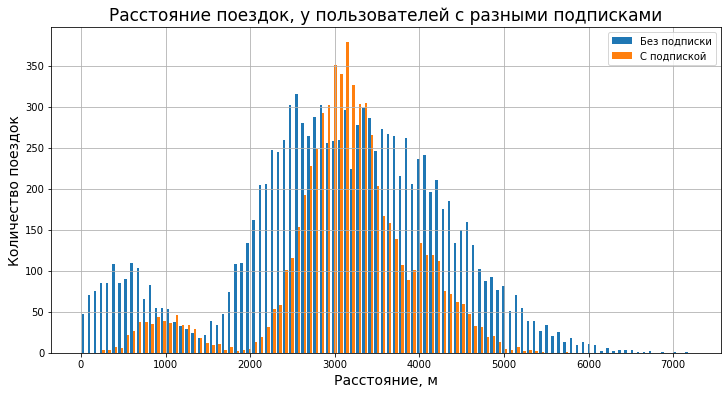

In [30]:
# Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий
print('Информация о дальности поездок с подпиской:\n',data_ultra['distance'].describe())
print()
print('Информация о дальности поездок без подписки:\n',data_free['distance'].describe())
plt.figure(figsize =(12,6))
plt.hist([data_free['distance'], data_ultra['distance']], bins = 100)
plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Расстояние, м', size = 14)
plt.ylabel('Количество поездок', size = 14)
plt.title('Расстояние поездок, у пользователей с разными подписками', size = 17)
plt.grid()
plt.show()

По графику видно, что оба распределения имеют вид довольно близкий к нормальному, за исключением области до 1.5 км. А так, заметно, что у пользователей без подписки больший разброс по расстоянию, а у людей с подпиской более выражено среднее значение, равное чуть больше 3 км. Пользователи без подписки чаще всего проезжают от 2.5 до 3.5 км.

Информация о продолжительности поездок без подписки:
 count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

Информация о продолжительности поездок с подпиской:
 count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


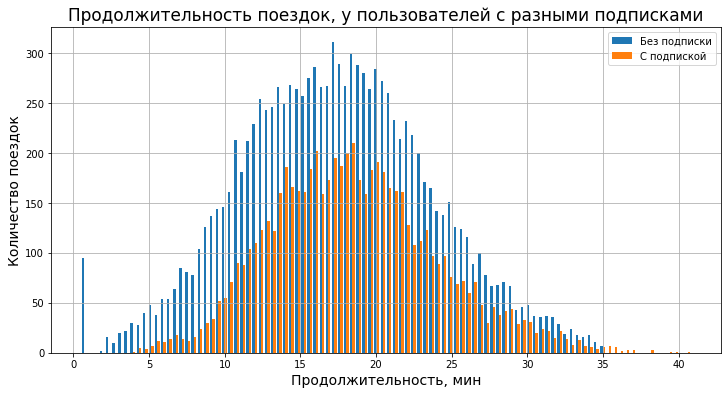

In [31]:
# Теперь выведем график по продолжительности поездок
print('Информация о продолжительности поездок без подписки:\n',data_free['duration'].describe())
print()
print('Информация о продолжительности поездок с подпиской:\n',data_ultra['duration'].describe())
plt.figure(figsize =(12,6))
plt.hist([data_free['duration'], data_ultra['duration']], bins = 100)
plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Продолжительность, мин', size = 14)
plt.ylabel('Количество поездок', size = 14)
plt.title('Продолжительность поездок, у пользователей с разными подписками', size = 17)
plt.grid()
plt.show()

За исключением 1 выброса около нуля можно с уверенностью сказать что продолжительность поездок у обоих категорий распределена нормально. Очень близки показатели разброса. Четкой зависимости между продолжительностью поездки и типом подписки не проглядывается.

В ходе объединения датафреймов выполнили:
- Объединили все датафреймы в один и убедились в успешности их объединения
- Создали два раздельных датафрейма для пользователей с подпиской и без
- Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий

#### Шаг 5. Подсчёт выручки

In [17]:
# Создадим датафрейм в котором объединим данные по пользователям
data['duration'] = np.ceil(data['duration'])
data_sum = data.groupby(['user_id','month'])['duration','distance'].agg(sum)

data_sum['count'] = data.groupby(['user_id','month'])['duration'].agg('count')
data_sum

/tmp/ipykernel_2441/627533904.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_sum = data.groupby(['user_id','month'])['duration','distance'].agg(sum)


duration      distance  count
user_id month                               
1       1          42.0   7027.511294      2
        4           7.0    754.159807      1
        8          46.0   6723.470560      2
        10         32.0   5809.911100      2
        11         56.0   7003.499363      3
...                 ...           ...    ...
1534    6          26.0   3409.468534      2
        8          48.0   7622.453034      2
        9          23.0   4928.173852      1
        11         78.0  13350.015305      4
        12         16.0   2371.711192      1

[11331 rows x 3 columns]

In [18]:
# Добавим в датафрейм информацию о стоимости минуты, старта и подписки
data_sum = data_sum.merge(data[['user_id','minute_price','start_ride_price','subscription_fee']], on = 'user_id', how = 'outer').drop_duplicates().reset_index(drop = True)
data_sum

,user_id,duration,distance,count,minute_price,start_ride_price,subscription_fee
0,1,42.0,7027.511294,2,6,0,199
1,1,7.0,754.159807,1,6,0,199
2,1,46.0,6723.470560,2,6,0,199
3,1,32.0,5809.911100,2,6,0,199
4,1,56.0,7003.499363,3,6,0,199
...,...,...,...,...,...,...,...
11326,1534,26.0,3409.468534,2,8,50,0
11327,1534,48.0,7622.453034,2,8,50,0
11328,1534,23.0,4928.173852,1,8,50,0
11329,1534,78.0,13350.015305,4,8,50,0


In [19]:
# Добавим колонки с помесячной выручкой
data_sum['revenue'] = data_sum['start_ride_price']*data_sum['count']+data_sum['minute_price']*data_sum['duration']+data_sum['subscription_fee']
data_sum

,user_id,duration,distance,count,minute_price,start_ride_price,subscription_fee,revenue
0,1,42.0,7027.511294,2,6,0,199,451.0
1,1,7.0,754.159807,1,6,0,199,241.0
2,1,46.0,6723.470560,2,6,0,199,475.0
3,1,32.0,5809.911100,2,6,0,199,391.0
4,1,56.0,7003.499363,3,6,0,199,535.0
...,...,...,...,...,...,...,...,...
11326,1534,26.0,3409.468534,2,8,50,0,308.0
11327,1534,48.0,7622.453034,2,8,50,0,484.0
11328,1534,23.0,4928.173852,1,8,50,0,234.0
11329,1534,78.0,13350.015305,4,8,50,0,824.0


Получили таблицу, в которой есть колонка, отображающая помесячную выручку от каждого пользователя. Можем визуализировать эти данные и посмотреть, как влияет тип подписки на то, сколько пользователи тратят денег.

Информация о прибыли в месяц без подписки:
 count    6798.000000
mean      328.641365
std       183.868330
min        58.000000
25%       194.000000
50%       274.000000
75%       428.000000
max      1444.000000
Name: revenue, dtype: float64

Информация о прибыли в месяц с подпиской:
 count    4533.000000
mean      362.792191
std        88.262737
min       223.000000
25%       301.000000
50%       337.000000
75%       409.000000
max       955.000000
Name: revenue, dtype: float64


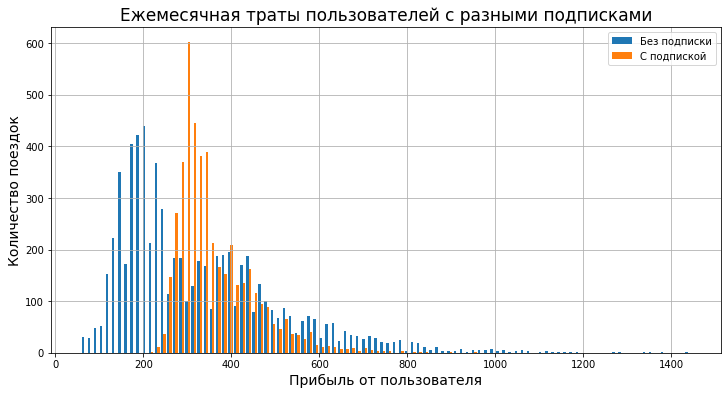

In [20]:
data_free2 = data_sum.query('start_ride_price == 50').reset_index(drop = True)
data_ultra2 = data_sum.query('start_ride_price == 0').reset_index(drop = True)
print('Информация о прибыли в месяц без подписки:\n',data_free2['revenue'].describe())
print()
print('Информация о прибыли в месяц с подпиской:\n',data_ultra2['revenue'].describe())
plt.figure(figsize =(12,6))
plt.hist([data_free2['revenue'], data_ultra2['revenue']], bins = 100)
plt.legend(['Без подписки', 'С подпиской'])
plt.xlabel('Прибыль от пользователя', size = 14)
plt.ylabel('Количество поездок', size = 14)
plt.title('Ежемесячная траты пользователей с разными подписками', size = 17)
plt.grid()
plt.show()

Видим, что распределения имеют похожий вид, но пиковые значения графика пользователей с подпиской смещены в право. Это значит, что основная часть людей, у которых есть подписка, тратят в месяц больше, чем те, у кого подписки нет. Если взглянуть на значение среднего, то оно тоже больше у пользователей с подпиской.

#### Шаг 6. Проверка гипотез

Проверка гипотезы №1

H₀: среднее время поездки пользователей с подпиской = среднему времени поездки пользователей без подписки.  
H₁: среднее время поездки пользователей с подпиской > среднему времени поездки пользователей без подписки.  

Уровень значимости α = 0.05.

In [32]:
alpha = 0.05
results = st.ttest_ind(data_ultra['duration'], data_free['duration'], equal_var = False, alternative = 'greater')
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-значение: 5.6757813771289775e-37
Отвергаем гипотезу


Для проверки использовали t-тест так как выборки имеют разный размер, аргумент equal_var выставлен в значение False.  

Полученное p-значение значительно меньше уровня значимости (p < 0.05), поэтому нулевая гипотеза отвергнута. Это означает, что пользователи с подпиской действительно проводят в поездках больше времени, чем пользователи бесплатного тарифа.

Проверка гипотезы №2

H₀: среднее расстояние поездки пользователей с подпиской = 3130 м.  
H₁: среднее расстояние поездки пользователей с подпиской < 3130 м.  

Уровень значимости α = 0.05.

In [36]:
interested_value = 3130

results2 = st.ttest_1samp(data_ultra['distance'], interested_value, alternative = 'less')
print('p-значение:', results2.pvalue)

if results2.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-значение: 0.08046311521502146
Не получилось отвергнуть гипотезу


Мы не смогли отвергнуть гипотезу. Не можем утверждать, что это неправда. Проверим среднее значение в ручную и удостовериться.

In [34]:
print('Среднее значение равно:', data_ultra['distance'].mean())
print('Медианное значение равно:', data_ultra['distance'].median())

Среднее значение равно: 3115.4453880370247
Медианное значение равно: 3148.6372291760854


p-значение = 0.080 > 0.05, поэтому нет оснований отвергнуть нулевую гипотезу.  
Среднее значение (≈ 3115 м) действительно близко к 3130 м, а медиана (≈ 3149 м) немного больше.  

Таким образом, данные не позволяют утверждать, что пользователи с подпиской проезжают в среднем меньше 3130 м. Среднее расстояние поездки можно считать статистически не отличающимся от 3130 м.

Проверка гипотезы №3

H₀: средняя ежемесячная выручка от пользователей с подпиской = средней ежемесячной выручке от пользователей без подписки.  
H₁: средняя ежемесячная выручка от пользователей с подпиской > средней ежемесячной выручке от пользователей без подписки.  

Уровень значимости α = 0.05.

In [24]:
results3 = st.ttest_ind(data_ultra2['revenue'], data_free2['revenue'], equal_var = False, alternative = 'greater')
print('p-значение:', results3.pvalue)
if results3.pvalue < alpha:
    print('Отвергаем гипотезу')
else:
    print('Не получилось отвергнуть гипотезу')

p-значение: 8.874140893976874e-40
Отвергаем гипотезу


Получили такое p-значение, что гипотеза точно отвергается. Выведем значения средних и сравним их.

In [25]:
print('Среднее значение ежемесячной выручки с подпиской:', data_ultra2['revenue'].mean())
print('Среднее значение ежемесячной выручки без подписки:', data_free2['revenue'].mean())

Среднее значение ежемесячной выручки с подпиской: 362.7921906022502
Среднее значение ежемесячной выручки без подписки: 328.6413651073845


Полученное p-значение ≈ 8.87e-40, что значительно меньше уровня значимости (α = 0.05).  
Следовательно, нулевую гипотезу отвергаем.  

Средняя ежемесячная выручка:  
- с подпиской ≈ 362.79  
- без подписки ≈ 328.64  

Это подтверждает, что пользователи с подпиской приносят больше выручки компании, чем пользователи без подписки. Привлечение пользователей на подписку действительно выгодно.

Подбор теста для проверки гипотезы о количестве обращений в поддержку:
- Нам нужно проверить гипотезу, в которой будут сравниваться значения из 2 файлов, в которых есть данные для каждого пользователя о количестве сообщений до и после обновления. Так как список пользователей остается одним и тем же, то будем иметь дело с двумя зависимыми выборками, с одинаковым количеством записей. В таком случае будем использовать метод scipy.stats.ttest_rel.

**Общий вывод**

Мы исследовали полученный датафрейм с данными о пользователях сервиса аренды самокатов GoFast из разных городов и сделали выводы насчет выгодности разных подписок, и можем составить портрет типичного пользователя.

- Исходные данные:
    - В данных не было пропусков, но встретилось несколько абсолютных дубликатов. Их количество было небольшим, и оно бы не сильно повлияло на дальнейшее исследование, поэтому было решено их просто удалить. Объединили все три датафрейма в один общий, в котором собрана абсолютна вся информация по каждой поездке и видно сколько она длилась, данные о пользователе и данные о типу подписки, по которому она совершалась.
- В ходе исследовательского анализа данных выяснили следующее:
    - Частота встречаемости городов
        - Больше всего пользуются сервисом в Пятигорске, Екатиренбурге и Ростове-на-Дону, а меньше всего в Москве, но различия незначительны.
    - Соотношение пользователей с подпиской и без подписки
        - Кол-во пользователей с подпиской ultra и без нее почти одинаково, но все равно большинство пользуется бесплатной версией.
    - Возраст пользователей
        - Распределение возрастов пользователей близко к нормальному виду. Больше всего пользователей 25 лет, хотя есть и значения и меньше 5 лет, и больше 45.
    - Расстояние, которое пользователь преодолел за одну поездку
        - График распределения киллометража имеет почти нормальный вид, помимо области до 1.5км. Это отклонение может говорить нам о том, что часть пользователей предпочитает пользоваться сервисом вместо недолгой прогулки или использования общ. транспорта. Самой частой дистанцией выступают значения от 3 до 3.5 км.
    - Продолжительность поездок
        - Получили нормальное распределение, с центром в значении около 17 минут. Значит это самая распространенная продолжительность, а остальные значения стремятся к нему. Так же были получены значения максимума и минимума. Пользователи проводили в поездке от 0.5 до 40 минут.
        
- В ходе объединения датафреймов выполнили:
    - Объединили все датафреймы в один и убедились в успешности их объединения
    - Создали два раздельных датафрейма для пользователей с подпиской и без
    - Визуализировали информацию о расстоянии и времени поездок для пользователей обеих категорий и выяснили:
        - Пользователи без подписки чаще всего проезжают от 2.5 до 3.5 км.
        - Четкой зависимости между продолжительностью поездки и типом подписки не проглядывается.

- По выводам из исследовательского анализа представим среднестатистического пользователя сервиса
    - Больше всего данных у нас из городов Пятигорск, Екатеринбург и Ростов-на-дону.
    - Большая часть пользователей пользуется подпиской free
    - Средний возраст пользователя - 25 лет
    - Среднее расстояние за 1 поездку - 3.3км
    - Среднее время сеанса - 17 минут

- Подсчет выручки
    - Создали датафрейм в котором объединим данные по пользователям
    - Добавили в датафрейм информацию о стоимости минуты, старта и подписки
    - Добавили колонки с помесячной выручкой
    - Визуализировали эти данные и посмотрели, как влияет тип подписки на то, сколько пользователи тратят денег, пришли к выводу:
        - Основная часть людей, у которых есть подписка, тратят в месяц больше, чем те, у кого подписки нет.

- Проверка гипотез
    - Проверили гипотезу, что среднее время у пользователей с подпиской больше чем среднее время пользователей на бесплатном тарифе, отвергли ее
    - Проверили гипотезу о том, что среднее расстояние поездки пользователя с подпиской не превышает 3130м, не смогли ее отвергнуть
    - Проверили гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки, не смогли отвергнуть ее
    
- Рекомендации по развитию сервиса

    - Продвигать подписку `ultra`: пользователи с подпиской приносят больше выручки, поэтому стоит стимулировать переход бесплатных пользователей на платный тариф.  
    - Локальные маркетинговые кампании: в городах с меньшей активностью (например, Москва) можно запускать акции и бонусы для привлечения новых пользователей.  
    - Акцент на средние поездки 3–3.5 км: большинство поездок именно этой длины, поэтому оптимизация тарифов и акций под этот диапазон может повысить выручку.  
    - Возрастная сегментация: основной пользователь — 25 лет, но есть и младшие/старшие категории. Рекомендуется продумывать предложения для разных возрастных групп (например, семейные тарифы или молодежные акции).  
    - Стимулировать длительные поездки: среднее время поездки около 17 минут; увеличение числа длительных поездок может дополнительно повышать выручку.